In [3]:
import os
if "models" not in os.listdir("."):
    os.chdir("../..")

In [4]:
%load_ext autoreload
%autoreload 2
import penzai
import jax_smi
jax_smi.initialise_tracking()
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained("models/gemma-2b-it.gguf", from_type="gemma", load_eager=True, device_map="tpu:0")

Exception in thread Thread-6 (inner):
Traceback (most recent call last):
  File "/home/dmitrii/.pyenv/versions/3.12.0/lib/python3.12/threading.py", line 1052, in _bootstrap_inner
    self.run()
  File "/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.12/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/home/dmitrii/.pyenv/versions/3.12.0/lib/python3.12/threading.py", line 989, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.12/lib/python3.12/site-packages/jax_smi/initialise_tracking.py", line 10, in inner
    posix.rename(f'{dir_prefix}/memory.prof.new', f'{dir_prefix}/memory.prof')  # atomic
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/dev/shm/memory.prof.new' -> '/dev/shm/memory.prof'


In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("alpindale/gemma-2b")
tokenizer.padding_side = "right"

In [7]:
from sprint.task_vector_utils import load_tasks, ICLRunner
tasks = load_tasks()

In [8]:
def check_if_single_token(token):
    return len(tokenizer.tokenize(token)) == 1

task_name = "es_en"

task = tasks[task_name]

print(len(task))

task = {
    k:v for k,v in task.items() if check_if_single_token(k) and check_if_single_token(v)
}

print(len(task))

pairs = list(task.items())

763
346


In [9]:
from sprint.task_vector_utils import logprob_loss
from functools import partial

sep = 3978
pad = 0

def metric_fn(logits, resids, tokens):
    return logprob_loss(logits, tokens, sep=sep, pad_token=pad, n_first=2)

In [10]:
from micrlhf.llama import LlamaBlock, LlamaAttention
from micrlhf.utils.activation_manipulation import ActivationAddition, wrap_vector
from functools import partial
import jax.numpy as jnp
from penzai import pz
import jax

@partial(jax.jit, static_argnames=("metric", "batched"))
def run_with_add(additions_pre, additions_mid, tokens, metric, batched=False, llama=None):
    get_resids = llama.select().at_instances_of(LlamaBlock).apply_with_selected_index(lambda i, x:
        pz.nn.Sequential([
            pz.de.TellIntermediate.from_config(tag=f"resid_pre_{i}"),
            x
        ])
    )
    get_resids = get_resids.select().at_instances_of(LlamaBlock).apply_with_selected_index(lambda l, b: b.select().at_instances_of(pz.nn.Residual).apply_with_selected_index(lambda i, x: x if i == 0 else pz.nn.Sequential([
        pz.de.TellIntermediate.from_config(tag=f"resid_mid_{l}"),
        x,
    ])))


    get_resids = get_resids.select().at_instances_of(LlamaAttention).apply_with_selected_index(lambda i, x: x.select().at_instances_of(pz.nn.Softmax).apply(lambda b: pz.nn.Sequential([
        b,
        pz.de.TellIntermediate.from_config(tag=f"attn_{i}"),
    ])))

    get_resids = pz.de.CollectingSideOutputs.handling(get_resids, tag_predicate=lambda x: True)
    make_additions = get_resids.select().at_instances_of(LlamaBlock).apply_with_selected_index(lambda i, x:
        pz.nn.Sequential([
            ActivationAddition(pz.nx.wrap(additions_pre[i], *(("batch",) if batched else ()), "seq", "embedding"), "all"),
            x
        ])
    )
    make_additions = make_additions.select().at_instances_of(LlamaBlock).apply_with_selected_index(lambda l, b: b.select().at_instances_of(pz.nn.Residual).apply_with_selected_index(lambda i, x: x if i == 0 else pz.nn.Sequential([
        ActivationAddition(pz.nx.wrap(additions_mid[l], *(("batch",) if batched else ()), "seq", "embedding"), "all"),
        x,
    ])))
    tokens_wrapped = pz.nx.wrap(tokens, "batch", "seq")
    logits, resids = make_additions(llama.inputs.from_basic_segments(tokens_wrapped))
    return metric(logits.unwrap("batch", "seq", "vocabulary"), resids, tokens), (logits, resids[::3], resids[1::3], resids[2::3])


@partial(jax.jit, static_argnames=("metric",))
def get_metric_resid_grad(tokens, llama=llama, metric=metric_fn):
    additions = [jnp.zeros(tokens.shape + (llama.config.hidden_size,)) for _ in range(llama.config.num_layers)]
    batched = tokens.ndim > 1
    (metric, (logits, resids_pre, qk, resids_mid)), (grad_pre, grad_mid) = jax.value_and_grad(run_with_add, argnums=(0, 1), has_aux=True)(additions, additions, tokens, metric, batched=batched, llama=llama)
    return (
        metric,
        [r.value.unwrap("batch", "seq", "embedding") for r in resids_pre],
        [r.value.unwrap("batch", "seq", "embedding") for r in resids_mid],
        [r.value.unwrap("batch", "kv_heads", "q_rep", "seq", "kv_seq") for r in qk],
        grad_pre,
        grad_mid
    )


In [11]:
batch_size = 8 
n_shot=20
max_seq_len = 128
seed = 10

In [12]:
runner = ICLRunner(task_name, pairs, batch_size=batch_size, n_shot=n_shot, max_seq_len=max_seq_len, seed=seed)

In [13]:
from sprint.task_vector_utils import tokenized_to_inputs

train_tokens = runner.get_tokens(
    runner.train_pairs, tokenizer
)["input_ids"]

In [14]:
# train_tokens = jnp.asarray(train_tokens)
# train_tokens = jax.device_put(train_tokens, jax.sharding.NamedSharding(llama.mesh, jax.sharding.PartitionSpec("dp", "sp")))
# train_tokens = pz.nx.wrap(train_tokens, "batch", "seq").untag("batch").tag("batch")


In [15]:
metric_value, resids_pre, resids_mid, qk, grad_pre, grad_mid = get_metric_resid_grad(train_tokens, llama=llama)

In [16]:
from micrlhf.utils.load_sae import get_nev_it_sae_suite

In [17]:
layer = 12

In [18]:
sae = get_nev_it_sae_suite(layer=layer)

--2024-07-11 21:06:54--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l12-residual-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.74, 108.157.142.53, 108.157.142.55, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/482902b98aceb9c73042f4ebd95aa5742af2d793c8812407b806a3166900a2ef?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1720991214&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5MTIxNH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

In [19]:
def weights_to_resid(weights, sae):
    if "s_gate" in sae:
        weights = (weights > 0) * jax.nn.relu(weights * jax.nn.softplus(sae["s_gate"]) * sae.get("scaling_factor", 1.0) + sae["b_gate"])   
    else:
        weights = jax.nn.relu(weights)

    recon = jnp.einsum("fv,bsf->bsv", sae["W_dec"], weights)

    if "norm_factor" in sae:
        recon = recon / sae["norm_factor"]

    # recon = recon.astype('bfloat16')
    return recon

In [20]:
from micrlhf.utils.load_sae import sae_encode_gated



In [21]:
from tqdm.auto import tqdm

results_attn = []
results_resid = []

def sfc_simple(grad, resid, sae):
    pre_relu, post_relu, recon = sae_encode_gated(sae, resid)
    f = partial(weights_to_resid, sae=sae)

    sae_grad, = jax.vjp(f, post_relu)[1](grad,)
    indirect_effects = sae_grad * post_relu
    return indirect_effects
layers = [6,] + list(range(8, 17))
for layer in tqdm(layers):
    r_pre, r_mid, g_mid = resids_pre[layer], resids_mid[layer], grad_mid[layer]
    sae = get_nev_it_sae_suite(layer=layer, label="attn_out")
    indirect_effects = sfc_simple(g_mid, r_mid - r_pre, sae)
    display((indirect_effects > 0).sum(-1))
    results_attn.append(indirect_effects)

# for layer, (r_pre, g_pre) in enumerate(zip(resids_pre, grad_pre)):
for layer in tqdm(layers):
    r_pre, g_pre = resids_pre[layer], grad_pre[layer]
    sae = get_nev_it_sae_suite(layer=layer)
    indirect_effects = sfc_simple(g_pre, r_pre, sae)
    display((indirect_effects != 0).sum(-1))
    results_resid.append(indirect_effects)

  0%|          | 0/10 [00:00<?, ?it/s]

--2024-07-11 21:06:56--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l6-attn_out-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.74, 108.157.142.50, 108.157.142.55, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/e7813a161125cb72c2f539e8a329df103872ebe0f2714589cfc44b7d6fb1f307?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1720991216&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5MTIxNn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgvZ

# jax.Array int32(8, 128) [≥0, ≤149] zero:312 nonzero:712
  Array([[ 4, 12, 14, ...,  0,  0,  0],
         [ 4, 17, 12, ...,  0,  0,  0],
         [ 3, 16, 14, ...,  0,  0,  0],
         ...,
         [ 4, 11, 10, ...,  0,  0,  0],
         [ 1, 16, 16, ...,  0,  0,  0],
         [ 1, 10, 19, ...,  0,  0,  0]], dtype=int32)

--2024-07-11 21:06:59--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l8-attn_out-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.50, 108.157.142.53, 108.157.142.74, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.50|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/818e2aaa054ff1666e77883325a85a3494c975a70e2cc4bbcffed883ae08851e?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1720991219&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5MTIxOX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgvO

# jax.Array int32(8, 128) [≥0, ≤183] zero:312 nonzero:712
  Array([[ 1,  8, 21, ...,  0,  0,  0],
         [ 3,  9, 14, ...,  0,  0,  0],
         [ 4, 10, 14, ...,  0,  0,  0],
         ...,
         [ 4, 10, 11, ...,  0,  0,  0],
         [ 4,  7, 18, ...,  0,  0,  0],
         [ 4,  5, 19, ...,  0,  0,  0]], dtype=int32)

--2024-07-11 21:07:02--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l9-attn_out-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.50, 108.157.142.53, 108.157.142.55, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.50|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/4deb1770aadfd566e0e6af58ee77509609d4727efff621cc6a58a632fd9d3faa?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1720991222&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5MTIyMn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgvN

# jax.Array int32(8, 128) [≥0, ≤200] zero:313 nonzero:711
  Array([[  1,  29,  90, ...,   0,   0,   0],
         [  2,  32, 110, ...,   0,   0,   0],
         [  4,  29, 120, ...,   0,   0,   0],
         ...,
         [  4,  26, 127, ...,   0,   0,   0],
         [  4,  25, 107, ...,   0,   0,   0],
         [  4,  22, 108, ...,   0,   0,   0]], dtype=int32)

--2024-07-11 21:07:05--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l10-attn_out-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.50, 108.157.142.55, 108.157.142.74, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.50|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/39babf724ff5dedfd120501507cbf321ff1852aa39e246167bb0bd41dbabfc61?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1720991225&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5MTIyNX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

# jax.Array int32(8, 128) [≥0, ≤276] zero:312 nonzero:712
  Array([[ 6, 15, 54, ...,  0,  0,  0],
         [ 5, 16, 43, ...,  0,  0,  0],
         [ 3,  7, 47, ...,  0,  0,  0],
         ...,
         [ 4, 13, 52, ...,  0,  0,  0],
         [ 4, 17, 46, ...,  0,  0,  0],
         [ 4,  7, 35, ...,  0,  0,  0]], dtype=int32)

--2024-07-11 21:07:08--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l11-attn_out-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.74, 108.157.142.53, 108.157.142.50, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/90ccc335056eda8de67fa88e7a14a45fb46333e2347919379cf691e6339bc861?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1720991228&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5MTIyOH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

# jax.Array int32(8, 128) [≥0, ≤431] zero:314 nonzero:710
  Array([[ 1, 17, 51, ...,  0,  0,  0],
         [ 2, 12, 60, ...,  0,  0,  0],
         [ 1,  7, 54, ...,  0,  0,  0],
         ...,
         [ 1,  4, 67, ...,  0,  0,  0],
         [ 1,  7, 41, ...,  0,  0,  0],
         [ 0,  7, 45, ...,  0,  0,  0]], dtype=int32)

--2024-07-11 21:07:11--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l12-attn_out-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.55, 108.157.142.74, 108.157.142.50, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.55|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/ad7866788525c396bd6ad88d18634168f09cf11970f39c0cbe6745a00bc5f745?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1720991231&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5MTIzMX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

# jax.Array int32(8, 128) [≥0, ≤122] zero:313 nonzero:711
  Array([[ 2,  4, 17, ...,  0,  0,  0],
         [ 2,  0, 16, ...,  0,  0,  0],
         [ 2,  4, 10, ...,  0,  0,  0],
         ...,
         [ 2,  2, 12, ...,  0,  0,  0],
         [ 2,  3,  6, ...,  0,  0,  0],
         [ 2,  4,  5, ...,  0,  0,  0]], dtype=int32)

--2024-07-11 21:07:14--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l13-attn_out-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.74, 108.157.142.55, 108.157.142.50, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/b125d1b97b0c7c727a6dd58fa37891519e4f59b50b13f4bdf766d9282a859924?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1720991234&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5MTIzNH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

# jax.Array int32(8, 128) [≥0, ≤178] zero:312 nonzero:712
  Array([[ 5, 11, 60, ...,  0,  0,  0],
         [ 3,  6, 40, ...,  0,  0,  0],
         [ 4,  9, 40, ...,  0,  0,  0],
         ...,
         [ 5,  9, 41, ...,  0,  0,  0],
         [ 4, 13, 48, ...,  0,  0,  0],
         [ 5, 13, 47, ...,  0,  0,  0]], dtype=int32)

--2024-07-11 21:07:17--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l14-attn_out-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.55, 108.157.142.53, 108.157.142.50, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.55|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/71d5a89d5d7288b6887aa7d7a6f1ff8ed9d7cb3b57be4b33b34b170156da05b6?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1720991238&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5MTIzOH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

# jax.Array int32(8, 128) [≥0, ≤53] zero:318 nonzero:706
  Array([[ 1, 29, 17, ...,  0,  0,  0],
         [ 0, 33, 18, ...,  0,  0,  0],
         [ 1, 37, 17, ...,  0,  0,  0],
         ...,
         [ 1, 35, 25, ...,  0,  0,  0],
         [ 1, 39, 20, ...,  0,  0,  0],
         [ 1, 33, 17, ...,  0,  0,  0]], dtype=int32)

--2024-07-11 21:07:21--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l15-attn_out-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.55, 108.157.142.50, 108.157.142.74, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.55|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/d724ec8b03aa35dec43c23b6e7fa6886abef69a3e5db62bb77bb173e2eda9d4e?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1720991241&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5MTI0MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

# jax.Array int32(8, 128) [≥0, ≤471] zero:313 nonzero:711
  Array([[ 2, 25, 74, ...,  0,  0,  0],
         [ 1, 23, 54, ...,  0,  0,  0],
         [ 3, 26, 57, ...,  0,  0,  0],
         ...,
         [ 0, 19, 63, ...,  0,  0,  0],
         [ 3, 25, 66, ...,  0,  0,  0],
         [ 3, 21, 62, ...,  0,  0,  0]], dtype=int32)

--2024-07-11 21:07:24--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l16-attn_out-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.74, 108.157.142.55, 108.157.142.50, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/63d2d3e062ca3027f5bc1c2bd5c47d9552fe02f4a2273e285f5d02f18702bbfa?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1720991244&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5MTI0NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

# jax.Array int32(8, 128) [≥0, ≤178] zero:314 nonzero:710
  Array([[ 5, 17, 74, ...,  0,  0,  0],
         [ 1, 23, 88, ...,  0,  0,  0],
         [ 5, 19, 79, ...,  0,  0,  0],
         ...,
         [ 5, 13, 74, ...,  0,  0,  0],
         [ 5, 19, 71, ...,  0,  0,  0],
         [ 5, 12, 77, ...,  0,  0,  0]], dtype=int32)

  0%|          | 0/10 [00:00<?, ?it/s]

--2024-07-11 21:07:27--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l6-residual-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.55, 108.157.142.53, 108.157.142.74, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.55|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/7983b92692afd876e25de0f7042ca4c7fdeee91d52438e95a1f85101878c2565?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1720991247&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5MTI0N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgvN

# jax.Array int32(8, 128) [≥0, ≤123] zero:312 nonzero:712
  Array([[ 3, 17, 29, ...,  0,  0,  0],
         [ 3, 17, 29, ...,  0,  0,  0],
         [ 3, 17, 29, ...,  0,  0,  0],
         ...,
         [ 3, 17, 29, ...,  0,  0,  0],
         [ 3, 17, 29, ...,  0,  0,  0],
         [ 3, 17, 29, ...,  0,  0,  0]], dtype=int32)

--2024-07-11 21:07:30--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l8-residual-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.53, 108.157.142.55, 108.157.142.74, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.53|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/ac42c841f31e9b75c96c4e9654d9d0bdc8a1037371b106ab8f7a450847c773f6?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1720991250&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5MTI1MH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgvY

# jax.Array int32(8, 128) [≥0, ≤121] zero:312 nonzero:712
  Array([[ 3, 16, 29, ...,  0,  0,  0],
         [ 3, 16, 29, ...,  0,  0,  0],
         [ 3, 16, 29, ...,  0,  0,  0],
         ...,
         [ 3, 16, 29, ...,  0,  0,  0],
         [ 3, 16, 29, ...,  0,  0,  0],
         [ 3, 16, 29, ...,  0,  0,  0]], dtype=int32)

--2024-07-11 21:07:33--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l9-residual-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.74, 108.157.142.50, 108.157.142.53, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/a6fc6365a258eeb906ac0c2e6970a08be66f6222b8c1b37f9f71b77447a75693?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1720991254&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5MTI1NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgvY

# jax.Array int32(8, 128) [≥0, ≤124] zero:312 nonzero:712
  Array([[ 2, 22, 27, ...,  0,  0,  0],
         [ 2, 22, 27, ...,  0,  0,  0],
         [ 2, 22, 27, ...,  0,  0,  0],
         ...,
         [ 2, 22, 27, ...,  0,  0,  0],
         [ 2, 22, 27, ...,  0,  0,  0],
         [ 2, 22, 27, ...,  0,  0,  0]], dtype=int32)

--2024-07-11 21:07:36--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l10-residual-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.74, 108.157.142.53, 108.157.142.50, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/98b3d7978c54df5f79f204da533ea3c1615d91ff92b245051df118a798a10913?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1720991256&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5MTI1Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

# jax.Array int32(8, 128) [≥0, ≤136] zero:312 nonzero:712
  Array([[ 3, 13, 34, ...,  0,  0,  0],
         [ 3, 13, 34, ...,  0,  0,  0],
         [ 3, 13, 34, ...,  0,  0,  0],
         ...,
         [ 3, 13, 34, ...,  0,  0,  0],
         [ 3, 13, 34, ...,  0,  0,  0],
         [ 3, 13, 34, ...,  0,  0,  0]], dtype=int32)

--2024-07-11 21:07:39--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l11-residual-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.74, 108.157.142.55, 108.157.142.50, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/28957e3bb381cf0760e15f81617bd08dbfc6c6999afc646aff68febfaf164da8?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1720991259&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5MTI1OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

# jax.Array int32(8, 128) [≥0, ≤133] zero:312 nonzero:712
  Array([[ 1, 14, 34, ...,  0,  0,  0],
         [ 1, 14, 34, ...,  0,  0,  0],
         [ 1, 14, 34, ...,  0,  0,  0],
         ...,
         [ 1, 14, 34, ...,  0,  0,  0],
         [ 1, 14, 34, ...,  0,  0,  0],
         [ 1, 14, 34, ...,  0,  0,  0]], dtype=int32)

# jax.Array int32(8, 128) [≥0, ≤125] zero:312 nonzero:712
  Array([[ 3, 14, 32, ...,  0,  0,  0],
         [ 3, 14, 32, ...,  0,  0,  0],
         [ 3, 14, 32, ...,  0,  0,  0],
         ...,
         [ 3, 14, 32, ...,  0,  0,  0],
         [ 3, 14, 32, ...,  0,  0,  0],
         [ 3, 14, 32, ...,  0,  0,  0]], dtype=int32)

--2024-07-11 21:07:43--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l13-residual-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.74, 108.157.142.50, 108.157.142.55, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/6461f46feb28c8c5352bc518eb2132affff5ae420c1b260245d91269777a6c95?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1720991264&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5MTI2NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

# jax.Array int32(8, 128) [≥0, ≤111] zero:312 nonzero:712
  Array([[ 3, 14, 36, ...,  0,  0,  0],
         [ 3, 14, 36, ...,  0,  0,  0],
         [ 3, 14, 36, ...,  0,  0,  0],
         ...,
         [ 3, 14, 36, ...,  0,  0,  0],
         [ 3, 14, 36, ...,  0,  0,  0],
         [ 3, 14, 36, ...,  0,  0,  0]], dtype=int32)

--2024-07-11 21:07:46--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l14-residual-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.74, 108.157.142.53, 108.157.142.50, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/742594e36e3a344059a04c814c7b98200e24a8159cc48e02714db7284b57308e?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1720991266&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5MTI2Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

# jax.Array int32(8, 128) [≥0, ≤94] zero:312 nonzero:712
  Array([[ 5, 16, 33, ...,  0,  0,  0],
         [ 5, 15, 33, ...,  0,  0,  0],
         [ 5, 15, 33, ...,  0,  0,  0],
         ...,
         [ 5, 15, 33, ...,  0,  0,  0],
         [ 5, 15, 33, ...,  0,  0,  0],
         [ 5, 16, 33, ...,  0,  0,  0]], dtype=int32)

--2024-07-11 21:07:49--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l15-residual-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.74, 108.157.142.50, 108.157.142.55, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/29620849d90931253a2f61009016485a3033984dcdf16db19acb8656c308f297?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1720991269&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5MTI2OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

# jax.Array int32(8, 128) [≥0, ≤128] zero:312 nonzero:712
  Array([[ 3, 22, 31, ...,  0,  0,  0],
         [ 3, 22, 31, ...,  0,  0,  0],
         [ 3, 22, 31, ...,  0,  0,  0],
         ...,
         [ 3, 22, 31, ...,  0,  0,  0],
         [ 3, 22, 31, ...,  0,  0,  0],
         [ 3, 22, 31, ...,  0,  0,  0]], dtype=int32)

--2024-07-11 21:07:52--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l16-residual-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.74, 108.157.142.55, 108.157.142.53, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/e7f9ef1af7b12c1b598bcdddd46a18eb0c21ad2e5716f761d9a7996c09d52b2e?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1720991272&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDk5MTI3Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

# jax.Array int32(8, 128) [≥0, ≤122] zero:312 nonzero:712
  Array([[ 4,  7, 31, ...,  0,  0,  0],
         [ 4,  7, 31, ...,  0,  0,  0],
         [ 4,  7, 31, ...,  0,  0,  0],
         ...,
         [ 4,  7, 31, ...,  0,  0,  0],
         [ 4,  7, 31, ...,  0,  0,  0],
         [ 4,  7, 31, ...,  0,  0,  0]], dtype=int32)

In [23]:
l0s = [
    (r[0] != 0). for r in results_resid 
]

(array([1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
        0., 1., 1., 1., 2., 0., 1., 3., 2., 1., 1., 2., 3., 3., 0., 1., 2.,
        3., 2., 0., 0., 1., 0., 2., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-5.77982973e-05, -5.66501913e-05, -5.55020852e-05, -5.43539791e-05,
        -5.32058693e-05, -5.20577632e-05, -5.09096571e-05, -4.97615511e-05,
        -4.86134450e-05, -4.74653389e-05, -4.63172328e-05, -4.51691230e-05,
        -4.40210169e-05, -4.28729109e-05, -4.17248048e-05, -4.05766987e-05,
        -3.94285926e-05, -3.82804828e-05, -3.71323767e-05, -3.59842707e-05,
        -3.48361646e-05, -3.36880585e-05, -3.25399524e-05, -3.13918463e-05,
        -3.02437384e-05, -2.90956305e-05, -2.79475244e-05, -2.67994183e-05,
        -2.56513122e-05, -2.45032043e-05, -2.33550982e-05, -2.22069921e-05,
        -2.10588842e-05, -1.99107781e-05, -1.87626720e-05, -1.76145659e-05,
        -1.64664580e-05, -1.53183519e-05, -1.41702449e-05, -1.30221388e-05,
        -1.18740318e-05, -1.07259248e-05, -9.57781867e-06, -8.42971167e-06,
        -7.28160512e-06, -6.13349857e-06, -4.98539202e-06, -3.83728548e-06,
        -2.68917870e-06, -1.54107204e-06, -3.92965376e-07,  7.55141286e-07,
         1.90324795e-06,  3.05135450e-06,  4.19946127e-06,  5.34756782e-06,
         6.49567437e-06,  7.64378092e-06,  8.79188792e-06,  9.93999402e-06,
         1.10881010e-05,  1.22362080e-05,  1.33843141e-05,  1.45324211e-05,
         1.56805272e-05,  1.68286351e-05,  1.79767412e-05,  1.91248473e-05,
         2.02729534e-05,  2.14210613e-05,  2.25691674e-05,  2.37172735e-05,
         2.48653814e-05,  2.60134875e-05,  2.71615936e-05,  2.83096997e-05,
         2.94578076e-05,  3.06059155e-05,  3.17540216e-05,  3.29021277e-05,
         3.40502338e-05,  3.51983399e-05,  3.63464460e-05,  3.74945521e-05,
         3.86426618e-05,  3.97907679e-05,  4.09388740e-05,  4.20869801e-05,
         4.32350862e-05,  4.43831923e-05,  4.55313020e-05,  4.66794081e-05,
         4.78275142e-05,  4.89756203e-05,  5.01237264e-05,  5.12718325e-05,
         5.24199386e-05,  5.35680483e-05,  5.47161544e-05,  5.58642605e-05,
         5.70123666e-05]),
 <BarContainer object of 100 artists>)

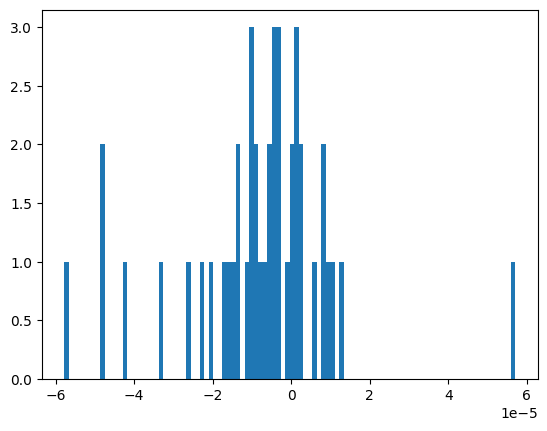

In [41]:
import matplotlib.pyplot as plt

plt.hist(
    results_resid[4][0][10][results_resid[4][0][10] != 0], bins=100
)

In [58]:
import numpy as np
from plotly import express as px
heatmaps = []
layer = layers.index(6)
batch_idx = 0
k = 24
# for s in results_resid[layer][batch_idx]:
for s in results_attn[layer][batch_idx]:
    if (s == 0).all():
        break
    _, idx = jax.lax.top_k(jnp.abs(s), k)
    heatmaps.append(s[idx])
arr = np.array(heatmaps).T
thresh = 1e-4
arr[np.abs(arr) < thresh] = 0
arr[arr == 0] = thresh / 10
arr = np.log(np.abs(arr))
# arr[arr != 0] = 1
px.imshow(arr, )

In [39]:
results_resid[0][0][10][results_resid[0][0][10] != 0]

# jax.Array float32(25,) ≈-4.2e-05 ±0.00015 [≥-0.00042, ≤0.00041] nonzero:25
  Array([-8.4977066e-05, -4.1760496e-04, -6.3441921e-06,  3.1496027e-06,
         -3.4434146e-05,  4.0719929e-04, -2.1137579e-04, -2.2960614e-05,
         -1.4515021e-05,  3.5267778e-05, -8.1178339e-05, -2.1922075e-04,
         -4.7008842e-05, -3.2350319e-05,  1.6011838e-04,  5.2611849e-05,
         -1.9370098e-05,  7.7059107e-05, -1.0959276e-04, -1.4432028e-05,
          4.3944117e-05,  2.8463379e-05, -1.1177973e-04, -2.7639270e-04,
         -1.4325435e-04], dtype=float32)

In [36]:
results_resid[0][0][10][results_resid[0][0][10] > 0]

# jax.Array float32(8,) ≈0.0001 ±0.00012 [≥3.1e-06, ≤0.00041] nonzero:8
  Array([3.1496027e-06, 4.0719929e-04, 3.5267778e-05, 1.6011838e-04,
         5.2611849e-05, 7.7059107e-05, 4.3944117e-05, 2.8463379e-05],      dtype=float32)

In [31]:
results_resid[0][0][10]

# jax.Array float32(32768,) ≈-3.2e-08 ±4.3e-06 [≥-0.00042, ≤0.00041] zero:32_743 nonzero:25
  Array([ 0.,  0., -0., ..., -0.,  0.,  0.], dtype=float32)

In [89]:
post_relu

<jax.Array float32(8, 128, 32768) ≈0.0014 ±0.39 [≥0.0, ≤8e+02] zero:33_518_636 nonzero:35_796>

In [90]:
sae_grad = jax.vjp(weights_to_resid, post_relu)[1](results[2][layer])

In [91]:
sae_grad

(<jax.Array float32(8, 128, 32768) ≈-5.4e-09 ±2.4e-05 [≥-0.037, ≤0.074] zero:33_526_736 nonzero:27_696>,)

In [69]:
sae_grad

(# jax.Array float32(32768,) ≈9.4e-11 ±1.7e-08 [≥-0.0, ≤3.1e-06] zero:32_767 nonzero:1
   Array([ 0.,  0.,  0., ..., -0., -0., -0.], dtype=float32)
 ,)

In [ ]:
post_relu.dtype

In [59]:
post_relu.shape     

(2048, 32768)

In [37]:
llama

LlamaTransformer(
  #╭┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄╮
  # Input: LlamaInputs(tokens=<tokens>, attention_mask=<attention mask>, positions=<positions>)
  # Output: <unnormalized logits>
  #╰┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄┄╯
  config=LlamaConfig(vocab_size=256000, hidden_size=2048, intermediate_size=16384, num_attention_heads=8, num_key_value_heads=1, head_dim=256, num_layers=18, parameter_dtype=jax.numpy.bfloat16, activation_dtype=jax.numpy.bfloat16, act_fn='gelu', resid_rescale=<jax.Array(45.25, dtype=float16)>),
  body=WithSideInputsFromInputTuple(handler_id='WithSideInputsFromInputTuple_2f504', body=Sequential(sublayers=[EmbeddingLookup(table=EmbeddingTable(embeddings=Parameter(value=<NamedArray bfloat16(| vocabulary:256000, embedding:2048) ≈0.0016 ±0.18 [≥-9.8, ≤6.0] zero:5_685_388 nonzero:518_602_612 (wrapping jax.Array)>, name='embed.embeddings'), vocabulary_axis='vocabulary')), ConstantRescale(by=<jax.Array(45.25, dtype=float16)>), WithConstantSideInputsNonPytree(handler_id='WithConstantSideInputsNonPytree_febf8', body=ConstrainedSharding(mesh=HandledSideInputRef(handler_id='WithConstantSideInputsNonPytree_febf8', tag='mesh'), axis_name_to_mesh_name=HandledSideInputRef(handler_id='WithConstantSideInputsNonPytree_febf8', tag='axis_name_to_mesh_name')), side_inputs={'axis_name_to_mesh_name': {'neurons': 'mp', 'kv_heads': 'mp', 'seq': 'sp', 'batch': 'dp', 'dp': 'dp', 'sp': 'sp', 'mp': 'mp'}, 'mesh': Mesh(device_ids=array([[[0]]]), axis_names=('dp', 'sp', 'mp'))}), Sequential(sublayers=[LlamaBlock(sublayers=[WithConstantSideInputsNonPytree(handler_id='WithConstantSideInputsNonPytree_febf8', body=ConstrainedSharding(mesh=HandledSideInputRef(handler_id='WithConstantSideInputsNonPytree_febf8', tag='mesh'), axis_name_to_mesh_name=HandledSideInputRef(handler_id='WithConstantSideInputsNonPytree_febf8', tag='axis_name_to_mesh_name')), side_inputs={'axis_name_to_mesh_name': {'neurons': 'mp', 'kv_heads': 'mp', 'seq': 'sp', 'batch': 'dp', 'dp': 'dp', 'sp': 'sp', 'mp': 'mp'}, 'mesh': Mesh(device_ids=array([[[0]]]), axis_names=('dp', 'sp', 'mp'))}), Residual(delta=Sequential(sublayers=[RMSLayerNorm(sublayers=[RMSStandardize(across=('embedding',), epsilon=<jax.Array(9.98378e-07, dtype=bfloat16)>), Linear(weights=Parameter(value=<NamedArray bfloat16(| embedding:2048) ≈2.6 ±1.4 [≥-0.27, ≤9.8] zero:9 nonzero:2_039 (wrapping jax.Array)>, name='blocks.0.pre_attn_norm.scale.weights'), in_axis_names=(), out_axis_names=())]), CastToDType(dtype=jax.numpy.bfloat16), LlamaAttention(input_to_query=Sequential(sublayers=[Linear(weights=Parameter(value=<NamedArray bfloat16(| embedding:2048, kv_heads:1, q_rep:8, projection:256) ≈2.2e-06 ±0.0086 [≥-0.21, ≤0.18] zero:68_150 nonzero:4_126_154 (wrapping jax.Array)>, name='blocks.0.attn.query.weights'), in_axis_names=('embedding',), out_axis_names=('kv_heads', 'q_rep', 'projection')), ApplyRoPE(embedding_axis='projection', max_wavelength=10000, positions=HandledSideInputRef(handler_id='WithSideInputsFromInputTuple_2f504', tag='positions')), ConstantRescale(by=<jax.Array(0.0625, dtype=bfloat16)>)]), input_to_key=Sequential(sublayers=[Linear(weights=Parameter(value=<NamedArray bfloat16(| embedding:2048, kv_heads:1, projection:256) ≈-5.5e-06 ±0.012 [≥-0.098, ≤0.1] zero:9_918 nonzero:514_370 (wrapping jax.Array)>, name='blocks.0.attn.key.weights'), in_axis_names=('embedding',), out_axis_names=('kv_heads', 'projection')), ApplyRoPE(embedding_axis='projection', max_wavelength=10000, positions=HandledSideInputRef(handler_id='WithSideInputsFromInputTuple_2f504', tag='positions')), CastToDType(dtype=jax.numpy.bfloat16)]), input_to_value=Sequential(sublayers=[Linear(weights=Parameter(value=<NamedArray bfloat16(| embedding:2048, kv_heads:1, projection:256) ≈5.4e-05 ±0.017 [≥-0.25, ≤0.23] zero:13_577 nonzero:510_711 (wrapping jax.Array)>, name='blocks.0.attn.value.weights'), in_axis_names=('embedding',), out_axis_names=('kv_heads', 'projection')), CastToDType(dtype=jax.numpy.bfloat16)]), query_key_to_at